# Capstone Project 1 for Machine Learning Zoom Camp 2023

# DTC Zoomcamp Q&A Challenge

# Table of Contents
- [Problem description](#problem_description)
    - [Dataset Description](#about_dataset)
- [Exploratory Data Analysis (EDA)](#eda)
- [Feature Engineering](#fe)
    - [External Data](#external_data)
    - [Contextual Features](#contextual_features)
- [Model training](#model_training)
    - [Сosine similarity](#cosine_similarity)
    - [BERT](#bert)
- [Chosen model](#model)

# Problem description
<a id='problem_description'></a>

### Overview
The primary goal is to develop a model that can accurately match a given question to its correct answer using the provided dataset. This challenge will test your skills in text processing, understanding contextual relationships, and dealing with varied data formats, including text and images.

### Problem
I aim to develop a machine learning model that can predict answers.

DataTalks.Club, a hub for data science learning, generates a significant amount of Q&A data through its courses. This model aims to harness this data to create models that can automate the matching of questions to answers, enhancing educational resources and learner experiences.

### Impact 
Successful models from this competition could revolutionize how we manage the content, making it easier for learners to find the answers.

The data can downloaded from [kaggle](https://www.kaggle.com/competitions/dtc-zoomcamp-qa-challenge/data).

## Dataset Description
<a id='about_dataset'></a>
		
The dataset for the DataTalks.Club Q&A Matching Challenge consists of four CSV files and an attachments folder. These files contain questions and answers from DataTalks.Club courses, along with relevant metadata. Participants are expected to use these files to develop models that can accurately match questions to their correct answers.

1. **train_questions.csv**:
    Purpose: This file is used for training your model. It contains the questions along with metadata and the correct answer IDs.
    Columns:
    - question_id: A unique identifier for each question.
    - question: The text of the question.
    - course: The specific course from which the question was sourced.
    - year: The year in which the course was conducted.
    - candidate_answers: A list of answer IDs that are potential matches for the question.
    - answer_id: The ID of the actual correct answer for the question.
2. **train_answers.csv**:
    Purpose: This file provides the answers for training, corresponding to the questions in train_questions.csv.
    Columns:
    - answer_id: A unique identifier for each answer.
    - answer: The text of the answer.
    - course: The specific course from which the answer was sourced.
    - year: The year in which the course was conducted.
    - attachments_files: Names of any attachment files related to the answer, including images.
3. **test_questions.csv**:
    Purpose: Contains questions for evaluating your model's performance. It does not include the correct answer IDs.
    Columns: Same as train_questions.csv, but excluding the answer_id column.
4. **test_answers.csv**:
    Purpose: Provides the answers for the test set. Participants need to match these answers to the questions in test_questions.csv.
    Columns: Same as train_answers.csv.
5. **Attachments Folder**:
    Contents: Contains all the attachment files that are referenced in the answers. This includes images and potentially other types of files.
    Usage: These attachments are part of some answers and can be critical for correctly matching questions to answers, especially for questions where visual context is important.

# Exploratory Data Analysis (EDA)
<a id='eda'></a>

In [270]:
import pandas as pd
import numpy as np
import torch
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import io

from tqdm.auto import tqdm

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

from transformers import BertTokenizer, BertModel, AutoTokenizer, AutoModelForQuestionAnswering
from sentence_transformers import SentenceTransformer,util

from torchvision import transforms
import torchvision.models as models

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mutual_info_score, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay,accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, KFold

import warnings
warnings.filterwarnings('ignore')

In [271]:
data_path = '/Users/olga/github/ml-zoomcamp/capstone_project1/data/'
attachments_path = '/Users/olga/github/ml-zoomcamp/capstone_project1/data/attachments/'

train_questions_df = pd.read_csv(f'{data_path}/train_questions.csv')
train_answers_df = pd.read_csv(f'{data_path}/train_answers.csv')
test_questions_df = pd.read_csv(f'{data_path}/test_questions.csv')
test_answers_df = pd.read_csv(f'{data_path}/test_answers.csv')

Merge the train questions and answers in one dataframe.

In [272]:
train_merged_df = pd.merge(train_questions_df, train_answers_df, 
                           on='answer_id', 
                           how='inner', 
                           suffixes=('_question', '_answer'))

In [273]:
train_merged_df.head()

,question_id,question,course_question,year_question,candidate_answers,answer_id,answer,course_answer,year_answer,attachments_files
0,79062,"For categorical target set, where the distribu...",Machine Learning Zoomcamp,2021,"156400,754877,105368,643810,912439",156400,Alexey\nShould we use something non-standard t...,Machine Learning Zoomcamp,2021,NaN
1,468946,Is there anything that we are not allowed to u...,Machine Learning Zoomcamp,2021,"641330,634887,912439,425941,642829",634887,"No, I don't think there is anything you cannot...",Machine Learning Zoomcamp,2021,NaN
2,968800,I have been catching up and have been doing ho...,Data Engineering Zoomcamp,2022,"954016,167856,75919,36798,838013",954016,"Alexey\nYes, you will be. You can submit the p...",Data Engineering Zoomcamp,2022,NaN
3,688404,Could you please explain what code we should l...,Data Engineering Zoomcamp,2022,"198661,629898,686577,3699,141765",3699,Alexey\nI think the question refers to the hom...,Data Engineering Zoomcamp,2022,NaN
4,63921,Is it just me or does the model have really ba...,Machine Learning Zoomcamp,2021,"754877,604487,912439,858915,425941",858915,"Dmitry\nIt's fine, because this is the showcas...",Machine Learning Zoomcamp,2021,NaN


In [274]:
# Define a function to load the image from the file path
def load_image(file_path):
    if pd.isna(f'{attachments_path}{file_path}') or not os.path.exists(f'{attachments_path}{file_path}'):
        return None  # Return None if the file path is missing or the file does not exist
    image = Image.open(f'{attachments_path}{file_path}')
    img_byte_arr = io.BytesIO()
    image.save(img_byte_arr, format='JPEG')
    img_byte_arr = img_byte_arr.getvalue()
    return img_byte_arr

# Add the image to the DataFrame
train_merged_df['image'] = train_merged_df['attachments_files'].apply(load_image)

In [275]:
train_merged_df.describe()

,question_id,year_question,answer_id,year_answer
count,399.000000,399.000000,399.000000,399.000000
mean,461743.022556,2021.496241,505062.230576,2021.496241
std,282100.482395,0.500614,280573.093623,0.500614
min,26.000000,2021.000000,3699.000000,2021.000000
25%,219522.000000,2021.000000,244788.000000,2021.000000
50%,436482.000000,2021.000000,516218.000000,2021.000000
75%,686589.500000,2022.000000,750012.000000,2022.000000
max,994378.000000,2022.000000,998091.000000,2022.000000


In [276]:
train_merged_df.isnull().sum()

question_id            0
question               0
course_question        0
year_question          0
candidate_answers      0
answer_id              0
answer                 0
course_answer          0
year_answer            0
attachments_files    374
image                380
dtype: int64

In [277]:
train_merged_df=train_merged_df.drop_duplicates()

In [278]:
train_merged_df.shape

(397, 11)

In [279]:
train_merged_df['question'].nunique()

396

In [280]:
train_merged_df = train_merged_df.drop_duplicates(subset=['question'])

In [281]:
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text

In [282]:
train_merged_df['cleaned_question'] = train_merged_df['question'].apply(clean_text)
train_merged_df['cleaned_answer'] = train_merged_df['answer'].apply(clean_text)

[nltk_data] Downloading package stopwords to /Users/olga/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


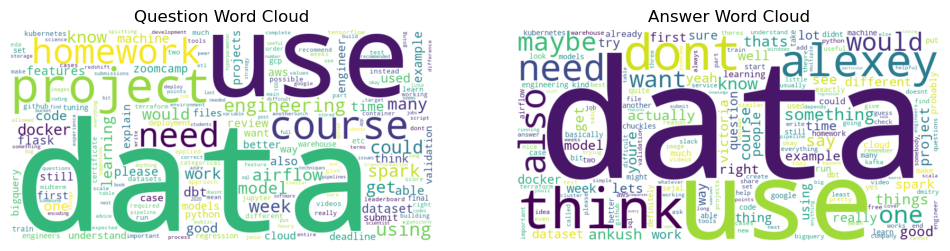

In [283]:
# Analyze the content of the text (assuming the text is stored in the question and answer columns)
# Compute the frequency of words in the questions and answers
question_words = ' '.join(train_merged_df['cleaned_question']).split()
answer_words = ' '.join(train_merged_df['cleaned_answer']).split()
question_word_freq = pd.Series(question_words).value_counts()
answer_word_freq = pd.Series(answer_words).value_counts()

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

question_word_freq = {k: v for k, v in question_word_freq.items() if k not in stop_words}
answer_word_freq = {k: v for k, v in answer_word_freq.items() if k not in stop_words}
# Define the list of articles, pronouns, and prepositions
articles = ['a', 'an', 'the']
pronouns = ['i', 'you', 'he', 'she', 'it', 'we', 'they', 'me', 'him', 'her', 'us', 'them']
prepositions = ['about', 'above', 'across', 'after', 'against', 'along', 'among', 'around', 
                'at', 'before', 'behind', 'below', 'beneath', 'beside', 'between', 'beyond', 
                'but', 'by', 'concerning', 'considering', 'despite', 'down', 'during', 'except', 
                'for', 'from', 'in', 'inside', 'into', 'like', 'near', 'of', 'off', 'on', 'onto', 
                'out', 'outside', 'over', 'past', 'regarding', 'round', 'since', 'through', 'throughout', 
                'to', 'toward', 'under', 'underneath', 'until', 'up', 'upon', 'with', 'within', 'without']

# Filter out small words, articles, pronouns, and prepositions from answer_word_freq
filtered_question_word_freq = {k: v for k, v in question_word_freq.items() if len(k) > 2 
                             and k not in articles and k not in pronouns and k not in prepositions}

filtered_answer_word_freq = {k: v for k, v in answer_word_freq.items() if len(k) > 2 
                             and k not in articles and k not in pronouns and k not in prepositions}


# Plot the word clouds for questions and answers
question_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(filtered_question_word_freq)
answer_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(filtered_answer_word_freq)
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(question_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Question Word Cloud')
plt.subplot(122)
plt.imshow(answer_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Answer Word Cloud')
plt.show()

# Feature Engineering
<a id='fe'></a>

## External Data
<a id='external_data'></a>
Integrate external data thoughtfully.

In [284]:
# Define a function to load the image and convert it to a tensor
def load_image_as_tensor(file_path):
    if pd.isna(f'{attachments_path}{file_path}') or not os.path.exists(f'{attachments_path}{file_path}'):
        return None  # Return None if the file path is missing or the file does not exist
    image = Image.open(f'{attachments_path}{file_path}')
    # Define the transformations to be applied to the image
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    # Apply the transformations and return the image as a tensor
    return preprocess(image).unsqueeze(0)

# Assuming you have a DataFrame named 'df' and the image file paths are stored in a column named 'image_path'
train_merged_df['image_tensor'] = train_merged_df['attachments_files'].apply(load_image_as_tensor)

## Contextual Features 
<a id='contextual_features'></a>
Use course name and year for context-aware features.

In [285]:
train_merged_df['context_question'] = train_merged_df['cleaned_question'].apply(
    lambda x: f"{x} {train_merged_df['course_question']} {train_merged_df['year_question']}")

train_merged_df['context_answer'] = train_merged_df['cleaned_answer'].apply(
    lambda x: f"{x} {train_merged_df['course_answer']} {train_merged_df['year_answer']}")

In [286]:
train_merged_df.head()

,question_id,question,course_question,year_question,candidate_answers,answer_id,answer,course_answer,year_answer,attachments_files,image,cleaned_question,cleaned_answer,image_tensor,context_question,context_answer
0,79062,"For categorical target set, where the distribu...",Machine Learning Zoomcamp,2021,"156400,754877,105368,643810,912439",156400,Alexey\nShould we use something non-standard t...,Machine Learning Zoomcamp,2021,NaN,None,for categorical target set where the distribut...,alexey\nshould we use something nonstandard th...,None,for categorical target set where the distribut...,alexey\nshould we use something nonstandard th...
1,468946,Is there anything that we are not allowed to u...,Machine Learning Zoomcamp,2021,"641330,634887,912439,425941,642829",634887,"No, I don't think there is anything you cannot...",Machine Learning Zoomcamp,2021,NaN,None,is there anything that we are not allowed to u...,no i dont think there is anything you cannot u...,None,is there anything that we are not allowed to u...,no i dont think there is anything you cannot u...
2,968800,I have been catching up and have been doing ho...,Data Engineering Zoomcamp,2022,"954016,167856,75919,36798,838013",954016,"Alexey\nYes, you will be. You can submit the p...",Data Engineering Zoomcamp,2022,NaN,None,i have been catching up and have been doing ho...,alexey\nyes you will be you can submit the pro...,None,i have been catching up and have been doing ho...,alexey\nyes you will be you can submit the pro...
3,688404,Could you please explain what code we should l...,Data Engineering Zoomcamp,2022,"198661,629898,686577,3699,141765",3699,Alexey\nI think the question refers to the hom...,Data Engineering Zoomcamp,2022,NaN,None,could you please explain what code we should l...,alexey\ni think the question refers to the hom...,None,could you please explain what code we should l...,alexey\ni think the question refers to the hom...
4,63921,Is it just me or does the model have really ba...,Machine Learning Zoomcamp,2021,"754877,604487,912439,858915,425941",858915,"Dmitry\nIt's fine, because this is the showcas...",Machine Learning Zoomcamp,2021,NaN,None,is it just me or does the model have really ba...,dmitry\nits fine because this is the showcase ...,None,is it just me or does the model have really ba...,dmitry\nits fine because this is the showcase ...


# Model training
<a id='model_training'></a>

## Cosine similarity 
<a id='cosine_similarity'></a>
Use cosine similarity to find the matching answer_id for each question

In [287]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [288]:
train_merged_df["candidate_answers"] = train_merged_df["candidate_answers"].str.split(",")

q_emb = model.encode(train_merged_df["cleaned_question"].values,show_progress_bar=True)
ans_emb = model.encode(train_merged_df["cleaned_answer"].values,show_progress_bar=True)

train_ans_dict = {}
for idx,(_,row) in enumerate(tqdm(train_merged_df.iterrows(),total=len(train_merged_df))):
    train_ans_dict[f"{row['answer_id']}"] = ans_emb[idx]

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

In [291]:
preds = []
for idx,(_,row) in enumerate(tqdm(train_merged_df.iterrows(),total=len(train_merged_df))):
    if idx != -1:
        sim = []
        for ca in row["candidate_answers"]:
            cos_sim = util.cos_sim(q_emb[idx],train_ans_dict[f"{ca}"])
            sim.append(cos_sim.item())
        aidx = np.argmax(np.array(sim))
        preds.append(row["candidate_answers"][aidx])

  0%|          | 0/396 [00:00<?, ?it/s]

In [293]:
preds = np.array(preds)
accuracy = accuracy_score(train_merged_df.answer_id.values.ravel(),preds.astype(int).ravel())
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9091


## BERT 
<a id='bert'></a>
Consider advanced models like BERT for context understanding.

In [96]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Available device: {device}")

# Getting pre-trained BERT model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.to(device) # Move model to GPU

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [130]:
def get_bert_embeddings(text):
    """
    Function for getting text embeddings using BERT
    Returns one embedding as an average of the words embeddings of the text 
    """
    tokens = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    tokens = {key: value.to(device) for key, value in tokens.items()}
    
    with torch.no_grad():
        outputs = model(**tokens)
    return outputs['last_hidden_state'][0].mean(dim=0).cpu().numpy()

In [132]:
# Get questions and answers embeddings for the train part
train_question_embeddings = train_merged_df['context_question'].apply(get_bert_embeddings)
train_answer_embeddings = train_merged_df['context_answer'].apply(get_bert_embeddings)

# Normalization
scaler = StandardScaler()
train_question_embeddings_standardized = scaler.fit_transform(np.array(train_question_embeddings.tolist()))
train_answer_embeddings_standardized = scaler.transform(np.array(train_answer_embeddings.tolist()))

In [133]:
def get_predictions(df_questions, df_answers):
    """
    Function that finds the best answer to each question according to their similarity.
    """
    predicted_answers = []
    predicted_answer_ids = []

    for index, row in df_questions.iterrows():
        question_text = row['question']
        candidate_answer_ids = [int(answer_id) for answer_id in row['candidate_answers'].split(",")]

        # Getting questions embeddings
        question_embedding = get_bert_embeddings(question_text)
        question_embedding_standardized = scaler.transform(question_embedding.reshape(1, -1))

        # Getting answer candidate embeddings
        candidate_answers_df = df_answers[df_answers['answer_id'].isin(candidate_answer_ids)]
        candidate_answer_embeddings = candidate_answers_df['answer'].apply(get_bert_embeddings)
        candidate_answer_embeddings_standardized = scaler.transform(np.array(candidate_answer_embeddings.tolist()))

        # Calculating similarity between question and answers embeddings
        similarities = cosine_similarity(question_embedding_standardized, candidate_answer_embeddings_standardized).flatten()

        # Taking index of the best answer candidate
        best_answer_index = similarities.argmax()

        predicted_answer = candidate_answers_df.iloc[best_answer_index]['answer']
        predicted_answer_id = candidate_answers_df.iloc[best_answer_index]['answer_id']
        predicted_answers.append(predicted_answer)
        predicted_answer_ids.append(predicted_answer_id)
        
    return predicted_answer_ids, predicted_answers

In [134]:
train_predictions_df = pd.DataFrame({
    'question_id': train_questions_df['question_id'],     
    'question': train_questions_df['question'],
    'candidate_answers': train_questions_df['candidate_answers'],
    'answer_id': train_questions_df['answer_id'],
})

train_predictions_df['predicted_answer_id'], train_predictions_df['predicted_answer'] = \
    get_predictions(train_questions_df, train_answers_df)

In [136]:
accuracy = (train_predictions_df['predicted_answer'] == train_answers_df['answer']).mean()
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.6675


# Chosen model
<a id='model'></a>

Choose model with best accuracy - Cosine similarity. Repeat Cosine similarity for test data.

In [295]:
test_questions_df = test_questions_df.drop_duplicates(subset='question_id')
test_questions_df['cleaned_question'] = test_questions_df['question'].apply(clean_text)
test_answers_df['cleaned_answer'] = test_answers_df['answer'].apply(clean_text)

test_questions_df["candidate_answers"] = test_questions_df["candidate_answers"].str.split(",")


q_emb = model.encode(test_questions_df["cleaned_question"].values,show_progress_bar=True)
ans_emb = model.encode(test_answers_df["cleaned_answer"].values,show_progress_bar=True)

test_ans_dict = {}
for idx,(_,row) in enumerate(tqdm(test_answers_df.iterrows(),total=len(test_answers_df))):
    test_ans_dict[f"{row['answer_id']}"] = ans_emb[idx]

    
preds = []
for idx,(_,row) in enumerate(tqdm(test_questions_df.iterrows(),total=len(test_questions_df))):
    if idx != -1:
        sim = []
        for ca in row["candidate_answers"]:
            cos_sim = util.cos_sim(q_emb[idx],test_ans_dict[f"{ca}"])
            sim.append(cos_sim.item())
            
    
        aidx = np.argmax(np.array(sim))
        preds.append(row["candidate_answers"][aidx])

Batches:   0%|          | 0/17 [00:00<?, ?it/s]

Batches:   0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/516 [00:00<?, ?it/s]

  0%|          | 0/514 [00:00<?, ?it/s]

In [297]:
test_questions_df["predicted_answer_id"] = preds
test_questions_df.head()

,question_id,question,course,year,candidate_answers,cleaned_question,predicted_answer_id
0,707,How much of an effort would it be to use AWS i...,Data Engineering Zoomcamp,2023,"[336232, 337669, 258304, 47681, 767296]",how much of an effort would it be to use aws i...,767296
1,534450,Can you talk about linear regression and regul...,Machine Learning Zoomcamp,2022,"[231208, 282072, 86769, 573165, 138373]",can you talk about linear regression and regul...,231208
2,996163,Can you please explain the Python Black setup ...,Data Engineering Zoomcamp,2023,"[571892, 816559, 47681, 337669, 336232]",can you please explain the python black setup ...,571892
3,860215,How many portfolio projects apart from the cou...,Machine Learning Zoomcamp,2022,"[643931, 988549, 918931, 235894, 608866]",how many portfolio projects apart from the cou...,988549
4,980124,Can you talk more about the final project? Wha...,Data Engineering Zoomcamp,2023,"[384381, 337669, 258304, 47681, 747722]",can you talk more about the final project what...,384381


In [298]:
test_questions_df[["question_id","predicted_answer_id"]].to_csv("submit.csv",index=False)

In [299]:
test_questions_df[["question_id","predicted_answer_id"]].shape

(514, 2)